# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [ ]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
import find_throwing_trajectory
importlib.reload(find_throwing_trajectory)
from direct_col_dev import find_throwing_trajectory

meshcat = StartMeshcat()


## Run trajectory optimization to find the optimal trajectory

In [2]:
N = 10
initial_state = np.zeros(14)
q = np.zeros((7,))
q[0] = 0; q[1] = 0.8
theta = -np.arccos(q[1])
q[3] = theta/2; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta/2
initial_state[:7] = q
final_state = initial_state
# final_configuration = np.array([np.pi, 0])
tf = 3.0
x_traj, u_traj, prog,  _, _ = find_throwing_trajectory(N, initial_state, 1.3, tf=1, jumpheight_tol=5e-2)


optimal cost:  42868.140526092815
x_sol:  [[ 0.0000e+00  8.0000e-01 -0.0000e+00 -3.2000e-01  1.2900e+00 -6.4000e-01
   6.4000e-01  0.0000e+00  0.0000e+00  0.0000e+00 -0.0000e+00 -0.0000e+00
  -0.0000e+00 -0.0000e+00]
 [ 3.0000e-02  8.0000e-01  1.0000e-01 -2.0000e-01  1.3000e+00 -1.3000e-01
   1.8000e-01  1.6000e-01 -7.0000e-02  5.9000e-01 -3.2100e+00  9.3200e+00
   3.2400e+00 -4.0300e+00]
 [ 2.0000e-02  7.8000e-01  3.0000e-02 -1.7800e+00  2.8600e+00 -2.8000e-01
   2.5000e-01 -2.6000e-01 -1.5000e-01 -1.5600e+00 -1.8590e+01  3.9200e+00
  -8.9700e+00  1.3190e+01]
 [-2.0000e-02  7.8000e-01 -1.2000e-01 -2.6200e+00  2.5700e+00 -1.4800e+00
   1.9000e+00 -3.4000e-01  1.1000e-01 -1.2000e-01  6.9900e+00 -5.0800e+00
  -5.2400e+00  1.6400e+00]
 [-4.0000e-02  7.9000e-01  7.0000e-02 -1.2700e+00  1.2300e+00 -1.3700e+00
   1.1900e+00 -6.0000e-02 -5.0000e-02  3.0000e+00  3.1100e+00  4.2000e-01
  -4.0000e+00  9.5500e+00]
 [-3.0000e-02  8.1000e-01  4.8000e-01 -1.2900e+00  2.7100e+00 -3.2500e+00
   5.5500

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [16]:
from pydrake.all import AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams
# Create a MultibodyPlant for the arm
file_name = "/home/dhruv/Hop-Skip-and-Jump/models/planar_walker.urdf"

builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels(file_name)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()



# builder = DiagramBuilder()
# scene_graph = builder.AddSystem(SceneGraph())
# robot = builder.AddSystem(MultibodyPlant(0.0))
# robot.RegisterAsSourceForSceneGraph(scene_graph)
# Parser(plant=robot).AddModels(file_name)
# robot.WeldFrames(
#             robot.world_frame(),
#             robot.GetBodyByName("base").body_frame(),
#             RigidTransform.Identity()
# )
# robot.Finalize()

n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()
print(n_q, n_v, n_u)

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(u_traj_source.get_output_port(), plant.get_actuation_input_port())
# builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
# builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
# builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

# MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

vis_params = MeshcatVisualizerParams(publish_period=0.0005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)



diagram = builder.Build()
diagram.set_name("diagram")

simulator = Simulator(diagram)
simulator.Initialize()
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())

q = np.zeros((plant.num_positions(),))
q[0] = 0; q[1] = 0.8
theta = -np.arccos(q[1])
q[3] = theta/2; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta/2
plant.SetPositions(plant_context, q)



  
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(1);
timesteps = np.linspace(0, 1.0, 100)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = np.linalg.norm(u_traj.vector_values([t]))
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos[2])
  vel_list.append(u)

7 7 4


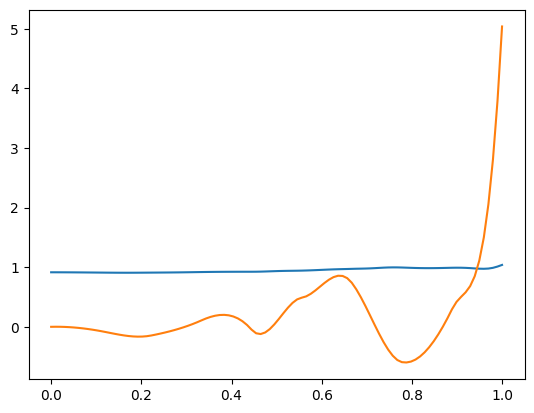

In [17]:
fig = plt.figure()
plt.plot(timesteps, com_pos_list)
plt.plot(timesteps,vel_list)
plt.show()

In [5]:
x_traj

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>